In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append('../src')
from lda import GibbsLDA
from sim import make_dataset
from utils import show_dataset

In [ ]:
import pyro
import torch
from pyro.distributions import constraints, Categorical, Dirichlet
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from base import HotTopic
from nets import OPTIM
from utils import kmeans

class PyroLDA(HotTopic):
    def __init__(self, n_topics=3, *, doc_size=10, vocab_size=10, tw_prior=.1, dt_prior=.1, optim='adam', desc='LDA'):
        pyro.clear_param_store()
        super().__init__(desc)

        self.n_topics = n_topics
        self.doc_size = doc_size
        self.vocab_size = vocab_size
        self.tw_prior = tw_prior
        self.dt_prior = dt_prior
        self.optim = optim

        self._n_steps = 1000
        self._tw_prior = self.tw_prior*torch.ones(self.vocab_size)
        self._dt_prior = self.dt_prior*torch.ones(self.n_topics)

    def _build(self, X, learning_rate=1e-1, batch_size=100):
        knn = torch.cdist(X, X).topk(self.doc_size, largest=False).indices
        self._docs = kmeans(X, self.vocab_size, verbosity=0)[knn].T
        self._optim = Adam({'lr': learning_rate})
        self._elbo = TraceEnum_ELBO(max_plate_nesting=2)
        self._svi = SVI(self._model, self._guide, self._optim, self._elbo)
        self._batch_size = batch_size

        return self
    
    def _model(self, X):
        with pyro.plate('topics', self.n_topics):
            tw_dists = pyro.sample('tw_dists', Dirichlet(self._tw_prior))

        with pyro.plate('docs', X.shape[1], self._batch_size) as mask:
            dt_dists = pyro.sample('dt_dists', Dirichlet(self._dt_prior))

            with pyro.plate('words', X.shape[0]):
                labels = pyro.sample('labels', Categorical(dt_dists), infer={'enumerate': 'parallel'})
                pyro.sample('values', Categorical(tw_dists[labels]), obs=X[:, mask])

        return self
    
    def _guide(self, X):
        self._tw_post = pyro.param('tw_post', lambda: torch.ones((self.n_topics, self.vocab_size)), constraint=constraints.greater_than(.5))
        self._dt_post = pyro.param('dt_post', lambda: torch.ones(X.shape[1], self.n_topics), constraint=constraints.greater_than(.5))

        with pyro.plate('topics', self.n_topics):
            pyro.sample('tw_dists', Dirichlet(self._tw_post))

        with pyro.plate('docs', X.shape[1], self._batch_size) as mask:
            pyro.sample('dt_dists', Dirichlet(self._dt_post[mask]))

        return self
    
    def _step(self):
        loss = self._svi.step(self._docs)

        return loss
    
    def _predict(self):
        labels = pyro.sample('dt_dists', Dirichlet(self._dt_post)).argmax(-1).detach()

        return labels

class LDA(HotTopic):  # TODO
    def __init__(self, n_topics=3, *, vocab_size=10, algorithm='gibbs', desc='LDA'):
        super().__init__(desc)

        self = PyroLDA(n_topics)

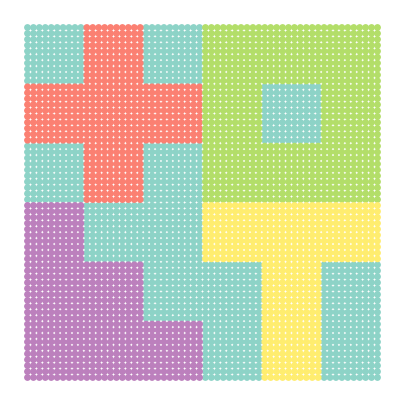

In [8]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

LDA: 100%|██████████| 1000/1000 [00:01<00:00, 508.97it/s]


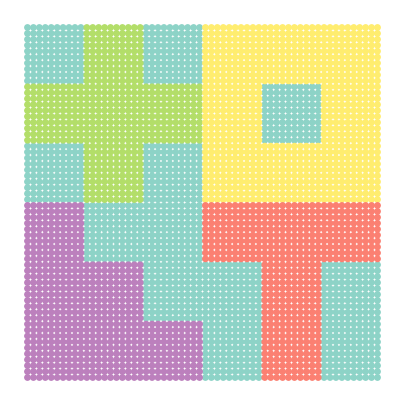

In [66]:
model = PyroLDA(5, tw_prior=.1, dt_prior=.1)
model.fit(data)
show_dataset(data, model.labels_)

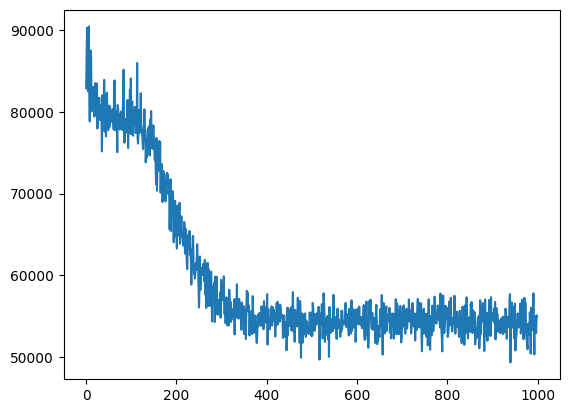

In [55]:
arr = torch.arange(len(model.log_))
plt.plot(arr, model.log_)

In [ ]:
import torch
from torch import nn
from base import HotTopic
from nets import OPTIM, MLP
from utils import relabel
        
class QAE(HotTopic, nn.Module):
    def __init__(self, max_topics=100, *, channels=(64, 32), optim='adam', desc='VQVAE', random_state=None):
        super().__init__(desc, random_state)

        self.max_topics = max_topics
        self.channels = channels
        self.optim = optim

        self._n_steps = 100
        
    def _build(self, X, learning_rate=1e-2, weight_decay=1e-2):
        in_channels = X.shape[-1]
        out_channels = (self.channels,) if isinstance(self.channels, int) else self.channels
        self._encoder = MLP(in_channels, *out_channels, norm_layer='batch', act_layer='relu')
        self._decoder = MLP(*out_channels[::-1], in_channels, norm_layer='batch', act_layer='relu')
        mask = torch.randperm(X.shape[0])[:self.max_topics]
        self._codebook = nn.Parameter(self._encoder(X)[mask], requires_grad=True)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        return self
    
    def _quantize(self, z, z_grad=False, c_grad=False, return_loss=False):
        embeddings = z if z_grad else z.detach()
        codebook = self._codebook if c_grad else self._codebook.detach()
        cdist = (embeddings[:, None] - codebook[None]).square().sum(-1)
        topics = cdist.argmin(-1)
        
        if return_loss:
            loss = cdist[torch.arange(topics.shape[0]), topics].sum()

            return topics, loss
        return topics
    
    def _evaluate(self, X, z):
        topics, z_loss = self._quantize(z, z_grad=True, return_loss=True)
        _, c_loss = self._quantize(z, c_grad=True, return_loss=True)
        X_ = self._decoder(self._codebook[topics])
        loss = z_loss + c_loss + (X_ - X).square().sum().sqrt()

        return loss
    
    def _step(self, X):
        z = self._encoder(X)
        loss = self._evaluate(X, z)
        loss.backward()
        self._optim.step()
        self._optim.zero_grad()

        return loss.item()
    
    def _predict(self, X, y=None):
        z = self._encoder(X)
        topics = relabel(self._quantize(z), y)

        return topics

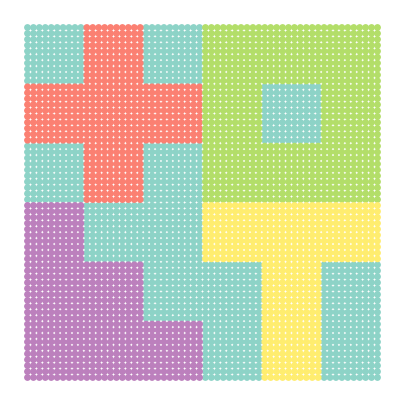

In [182]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

VQVAE: 100%|██████████| 100/100 [00:02<00:00, 34.26it/s]


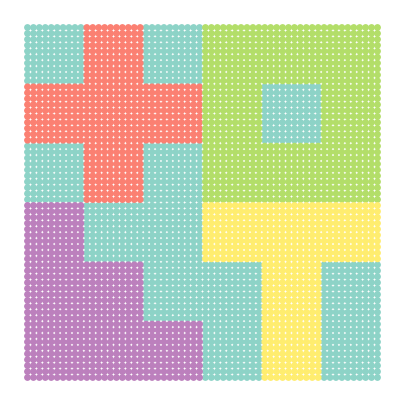

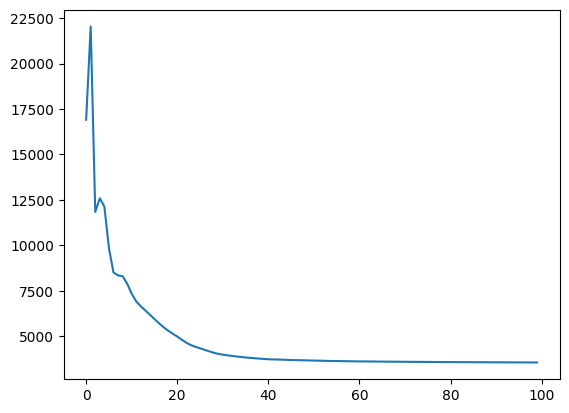

In [198]:
model = VQVAE()
model.fit(data[:, 3:])
show_dataset(data, model.labels_)
plt.show()
arr = torch.arange(len(model.log_))
plt.plot(arr, model.log_)
plt.show()

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

check_estimator(QAE(3))

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray